In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from alpha_vantage.timeseries import TimeSeries
from dotenv import load_dotenv
from datetime import datetime, timedelta
import yfinance as yf

plt.style.use('seaborn-v0_8-whitegrid')

load_dotenv()

API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')

if not API_KEY:
    raise ValueError("Please set your Alpha Vantage API key")


In [79]:
proxy='http://127.0.0.1:7890'
os.environ['HTTP_PROXY']=proxy
os.environ['HTTPS_PROXY']=proxy

In [90]:
def fetch_stock_data_AV(symbol, outputsize='full'):
    try:
        ts = TimeSeries(
            key=API_KEY,
            output_format='pandas',
            indexing_type='date'
        )

        data, meta_data = ts.get_daily(
            symbol=symbol,
            outputsize=outputsize
        )

        data = data.rename(columns={
            '1. open': 'open',
            '2. high': 'high',
            '3. low': 'low',
            '4. close': 'close',
            '5. volume': 'volume'
        })

        data = data[['open', 'high', 'low', 'close', 'volume']]

        data = data.sort_index()

        print(f"Successfully fetched data for {symbol}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
        print(f"Total records: {len(data)}")

        return data

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        raise

def load_local_stock_data(file_path):
    try:
        df = pd.read_csv(file_path, header=None)
        rows = df.iloc[3:].values
        stock_data=pd.DataFrame(rows, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
        stock_data['date'] = pd.to_datetime(stock_data['date'])
        stock_data['open'] = pd.to_numeric(stock_data['open'])
        stock_data['high'] = pd.to_numeric(stock_data['high'])
        stock_data['low'] = pd.to_numeric(stock_data['low'])
        stock_data['close'] = pd.to_numeric(stock_data['close'])
        stock_data['volume'] = pd.to_numeric(stock_data['volume'])

        stock_data = stock_data.set_index('date')
        return stock_data

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def fetch_stock_data_YH(symbol, start_date=None, end_date=None, period='max',save_local=True, data_dir='data'):
    try:
        if save_local and not os.path.exists(data_dir):
            os.makedirs(data_dir)

        filename = f"{symbol}_{period}"

        if start_date and end_date:
            filename = f"{symbol}_{start_date}_{end_date}"

        filename = f"{filename}.csv"
        filepath = os.path.join(data_dir, filename)

        if os.path.exists(filepath):
            print(f"Loading data from local file: {filepath}")
            data = pd.read_csv(filepath, index_col=0, parse_dates=True)
            print(f"Successfully loaded data for {symbol}")
            print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
            print(f"Total records: {len(data)}")
            return data
        else:
            print(f"Fetching data for {symbol} from yfinance...")
            if start_date and end_date:
                data = yf.download(symbol, start=start_date, end=end_date)
            else:
                data = yf.download(symbol, period=period)

        data = data.sort_index()

        data = data.rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })

        data = data[['open', 'high', 'low', 'close', 'volume']]

        if save_local:
            data.to_csv(filepath)
            print(f"Successfully saved data to local file: {filepath}")

        print(f"Successfully fetched data for {symbol}")
        print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
        print(f"Total records: {len(data)}")

        return data

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        raise

def calculate_moving_averages(df, short_window=5, long_window=20):
    data = df.copy()

    data['ma_short'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['ma_long'] = data['close'].rolling(window=long_window, min_periods=1).mean()

    return data

def generate_signals(df):
    data = df.copy(deep=True)

    data['signal'] = 0

    for i in range(1, len(data)):
        current_idx = data.index[i]
        prev_idx = data.index[i-1]

        if data.loc[current_idx, 'ma_short'] > data.loc[current_idx, 'ma_long'] and \
           data.loc[prev_idx, 'ma_short'] <= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = 1

        elif data.loc[current_idx, 'ma_short'] < data.loc[current_idx, 'ma_long'] and \
             data.loc[prev_idx, 'ma_short'] >= data.loc[prev_idx, 'ma_long']:
            data.loc[current_idx, 'signal'] = -1

    return data


In [91]:

def backtest(df, initial_capital=10000, transaction_cost=0.001):
    data = df.copy()

    data['cash'] = initial_capital
    data['shares'] = 0
    data['total'] = initial_capital
    data['returns'] = 0.0  # Daily returns
    data['strategy_cum_returns'] = 1.0  # Cumulative returns
    data['benchmark_cum_returns'] = 1.0  # Benchmark (buy and hold) cumulative returns

    trades = []
    current_cash = initial_capital
    current_shares = 0
    prev_price = data['close'].iloc[0]

    benchmark_cum_ret = 1.0

    for i in range(len(data)):
        date = data.index[i]
        price = data['close'].iloc[i]
        signal = data['signal'].iloc[i]

        daily_return = (price / prev_price) - 1
        benchmark_cum_ret *= (1 + daily_return)
        data.at[date, 'benchmark_cum_returns'] = benchmark_cum_ret
        prev_price = price

        if signal == 1 and current_shares == 0:
            max_shares = current_cash / (price * (1 + transaction_cost))
            shares_to_buy = int(max_shares)  # Buy whole shares

            if shares_to_buy > 0:
                cost = shares_to_buy * price * (1 + transaction_cost)
                current_cash -= cost
                current_shares += shares_to_buy

                trades.append({
                    'date': date,
                    'type': 'BUY',
                    'price': price,
                    'shares': shares_to_buy,
                    'cost': cost,
                    'cash_after': current_cash,
                    'shares_after': current_shares
                })

        elif signal == -1 and current_shares > 0:
            revenue = current_shares * price * (1 - transaction_cost)
            current_cash += revenue
            shares_sold = current_shares
            current_shares = 0

            trades.append({
                'date': date,
                'type': 'SELL',
                'price': price,
                'shares': shares_sold,
                'revenue': revenue,
                'cash_after': current_cash,
                'shares_after': current_shares
            })

        portfolio_value = current_cash + current_shares * price
        data.at[date, 'cash'] = current_cash
        data.at[date, 'shares'] = current_shares
        data.at[date, 'total'] = portfolio_value

        if i > 0:
            prev_portfolio = data['total'].iloc[i-1]
            data.at[date, 'returns'] = (portfolio_value / prev_portfolio) - 1
            data.at[date, 'strategy_cum_returns'] = data['strategy_cum_returns'].iloc[i-1] * (1 + data['returns'].iloc[i])

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df.set_index('date', inplace=True)

    return data, trades_df

def calculate_performance_metrics(backtest_results, trades_df):
    start_date = backtest_results.index[0]
    end_date = backtest_results.index[-1]
    days_traded = (end_date - start_date).days
    years_traded = days_traded / 365.25

    initial_value = backtest_results['total'].iloc[0]
    final_value = backtest_results['total'].iloc[-1]
    total_return = (final_value - initial_value) / initial_value * 100

    annualized_return = ((1 + total_return / 100) ** (1 / years_traded) - 1) * 100 if years_traded > 0 else 0

    benchmark_return = (backtest_results['benchmark_cum_returns'].iloc[-1] - 1) * 100
    benchmark_annualized = ((1 + benchmark_return / 100) ** (1 / years_traded) - 1) * 100 if years_traded > 0 else 0

    daily_returns = backtest_results['returns'].dropna()
    sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std()) if daily_returns.std() != 0 else 0

    rolling_max = backtest_results['total'].cummax()
    daily_drawdown = backtest_results['total'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100

    num_trades = len(trades_df)
    win_rate = 0
    avg_trade_return = 0

    if num_trades >= 2:
        winning_trades = 0
        total_trade_returns = 0

        for i in range(0, len(trades_df), 2):
            if i + 1 >= len(trades_df):
                break

            buy = trades_df.iloc[i]
            sell = trades_df.iloc[i+1]

            if sell['revenue'] > buy['cost']:
                winning_trades += 1

            trade_return = (sell['revenue'] - buy['cost']) / buy['cost'] * 100
            total_trade_returns += trade_return

        win_rate = (winning_trades / (num_trades / 2)) * 100 if num_trades > 0 else 0
        avg_trade_return = total_trade_returns / (num_trades / 2) if num_trades > 0 else 0

    return {
        'start_date': start_date.date(),
        'end_date': end_date.date(),
        'years_traded': round(years_traded, 2),
        'total_return': round(total_return, 2),
        'annualized_return': round(annualized_return, 2),
        'benchmark_return': round(benchmark_return, 2),
        'benchmark_annualized': round(benchmark_annualized, 2),
        'sharpe_ratio': round(sharpe_ratio, 2),
        'max_drawdown': round(max_drawdown, 2),
        'num_trades': num_trades,
        'win_rate': round(win_rate, 2),
        'avg_trade_return': round(avg_trade_return, 2)
    }


In [92]:

def plot_strategy(df, symbol, short_window, long_window, last_n_days=None):
    if last_n_days:
        cutoff_date = df.index.max() - timedelta(days=last_n_days)
        data = df[df.index >= cutoff_date]
        title_suffix = f" (Last {last_n_days} Days)"
    else:
        data = df
        title_suffix = ""

    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(data.index, data['close'], label='Close Price', linewidth=2, color='blue', alpha=0.7)
    ax.plot(data.index, data['ma_short'], label=f'{short_window}-Day MA', linewidth=2, color='orange')
    ax.plot(data.index, data['ma_long'], label=f'{long_window}-Day MA', linewidth=2, color='green')

    buy_signals = data[data['signal'] == 1]
    ax.scatter(buy_signals.index, buy_signals['close'],
              label='BUY Signal', marker='^', color='g', s=100, zorder=5)

    sell_signals = data[data['signal'] == -1]
    ax.scatter(sell_signals.index, sell_signals['close'],
              label='SELL Signal', marker='v', color='r', s=100, zorder=5)

    ax.set_title(f'{symbol} Price with {short_window}-Day and {long_window}-Day Moving Averages{title_suffix}',
                fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Price', fontsize=14, labelpad=10)
    ax.legend(fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()


def plot_performance(backtest_results, symbol, save_path=None):

    fig, ax = plt.subplots(figsize=(16, 10))

    ax.plot(backtest_results.index, backtest_results['strategy_cum_returns'],
            label='Strategy Returns', linewidth=2, color='blue')
    ax.plot(backtest_results.index, backtest_results['benchmark_cum_returns'],
            label='Buy & Hold Returns', linewidth=2, color='gray', linestyle='--')

    ax.set_title(f'{symbol} Strategy Performance vs Benchmark',
                fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=14, labelpad=10)
    ax.set_ylabel('Cumulative Returns', fontsize=14, labelpad=10)
    ax.legend(fontsize=12)

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Performance plot saved to: {save_path}")
    else:
        plt.show()


def print_performance_metrics(metrics):
    print("\n=== Strategy Performance Metrics ===")
    print(f"Date Range: {metrics['start_date']} to {metrics['end_date']}")
    print(f"Trading Period: {metrics['years_traded']} years")
    print("\n=== Returns ===")
    print(f"Total Strategy Return: {metrics['total_return']}%")
    print(f"Annualized Strategy Return: {metrics['annualized_return']}%")
    print(f"Total Benchmark Return (Buy & Hold): {metrics['benchmark_return']}%")
    print(f"Annualized Benchmark Return: {metrics['benchmark_annualized']}%")
    print("\n=== Risk Metrics ===")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']}")
    print(f"Maximum Drawdown: {metrics['max_drawdown']}%")
    print("\n=== Trading Statistics ===")
    print(f"Total Trades: {metrics['num_trades']}")
    print(f"Win Rate: {metrics['win_rate']}%")
    print(f"Average Trade Return: {metrics['avg_trade_return']}%")


In [80]:
SYMBOL = "AAPL"  # Tencent Holdings

print(f"Fetching data for {SYMBOL}...")
fetch_stock_data_YH(SYMBOL, period='3y')


Fetching data for AAPL...
Loading data from local file: data/AAPL_3y.csv
Successfully loaded data for AAPL
Error fetching data: 'str' object has no attribute 'date'


/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_77131/4260718025.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(filepath, index_col=0, parse_dates=True)


AttributeError: 'str' object has no attribute 'date'

In [93]:
stock_data = load_local_stock_data('data/AAPL_3y.csv')
stock_data

,open,high,low,close,volume
date,,,,,
2022-09-13,157.415135,158.045189,150.986613,151.449310,122656600
2022-09-14,152.384515,154.658630,151.222860,152.896439,87965400
2022-09-15,152.246719,152.827562,149.027546,150.002151,90481100
2022-09-16,148.860208,148.998032,146.064330,148.358124,162278800
2022-09-19,146.989705,152.158120,146.782977,152.079361,81474200
...,...,...,...,...,...
2025-09-08,239.300003,240.149994,236.339996,237.880005,48999500
2025-09-09,237.000000,238.779999,233.360001,234.350006,66313900
2025-09-10,232.190002,232.419998,225.949997,226.789993,83440800



Running strategy backtest...

=== Strategy Performance Metrics ===
Date Range: 2022-09-13 to 2025-09-12
Trading Period: 3.0 years

=== Returns ===
Total Strategy Return: 14.1%
Annualized Strategy Return: 4.5%
Total Benchmark Return (Buy & Hold): 54.55%
Annualized Benchmark Return: 15.63%

=== Risk Metrics ===
Sharpe Ratio: 0.35
Maximum Drawdown: -24.0%

=== Trading Statistics ===
Total Trades: 25
Win Rate: 16.0%
Average Trade Return: 0.75%

Latest data with signals:


/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_77131/3219505102.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.247622833252535' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[date, 'cash'] = current_cash
/var/folders/rf/fk21z0nj7wvc4x6py1jjp8dm0000gn/T/ipykernel_77131/3219505102.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9990.034213409424' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[date, 'total'] = portfolio_value


,close,ma_short,ma_long,signal
date,,,,
2025-08-29,232.139999,229.177998,215.381387,0
2025-09-02,229.720001,229.060999,215.960344,0
2025-09-03,238.470001,229.851999,216.704312,0
2025-09-04,239.779999,231.228999,217.498454,0
2025-09-05,239.690002,232.708000,218.265623,0
2025-09-08,237.880005,233.720001,219.007781,0
2025-09-09,234.350006,234.439001,219.677740,0
2025-09-10,226.789993,234.187001,220.114792,0
2025-09-11,230.029999,234.141000,220.563703,0


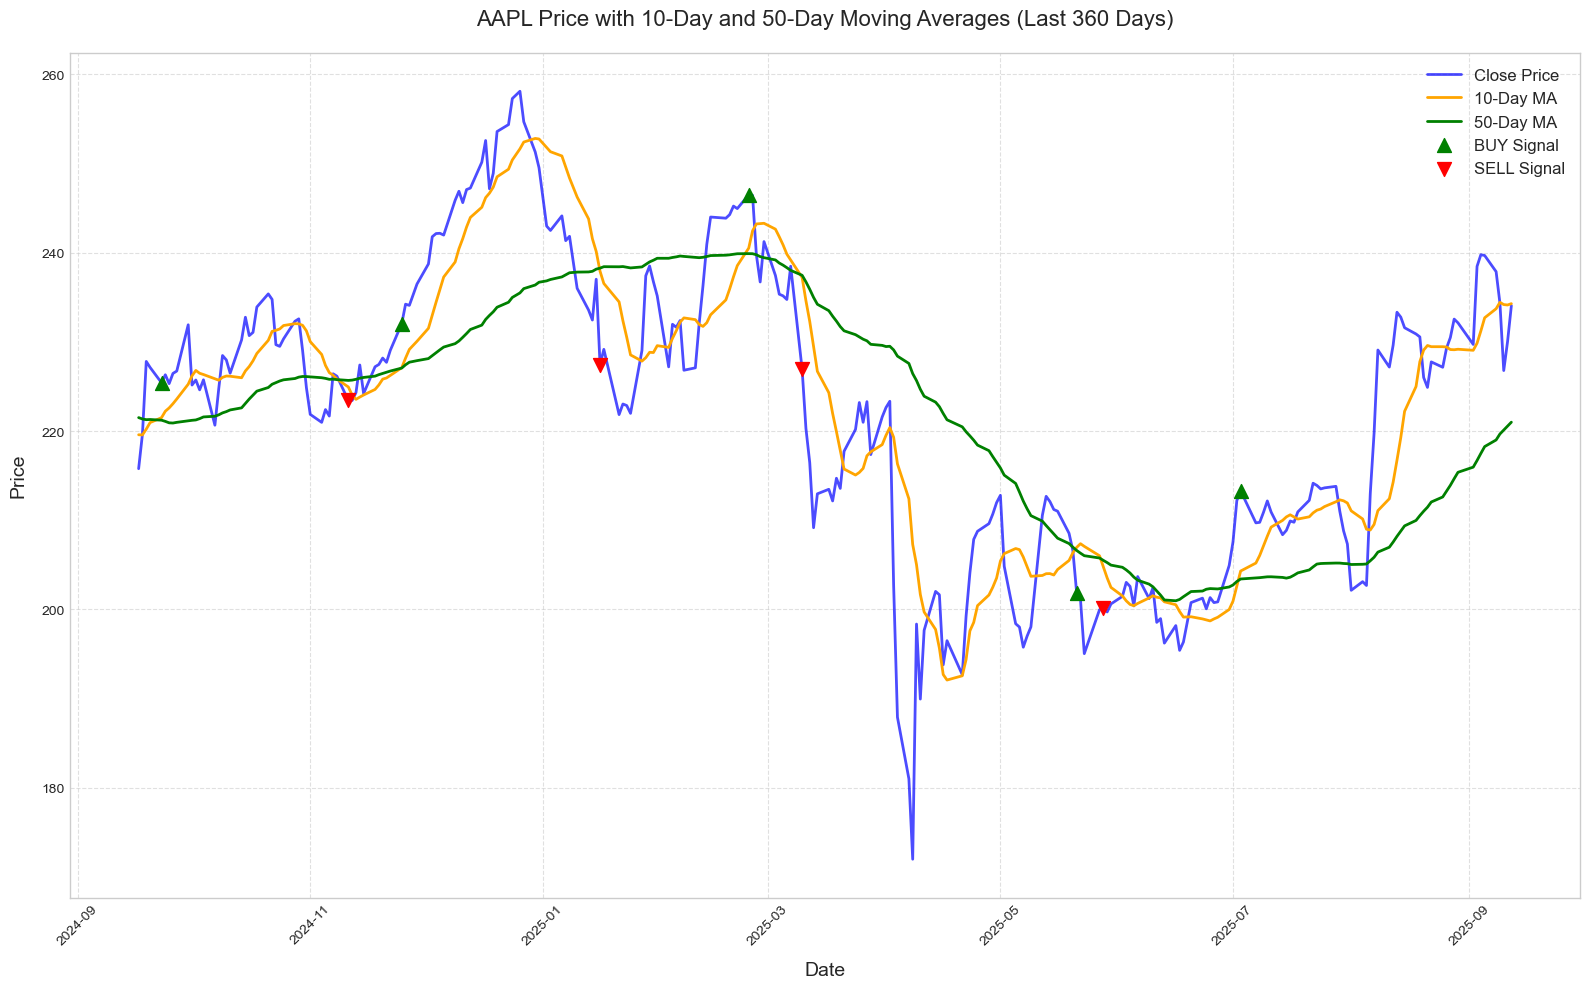

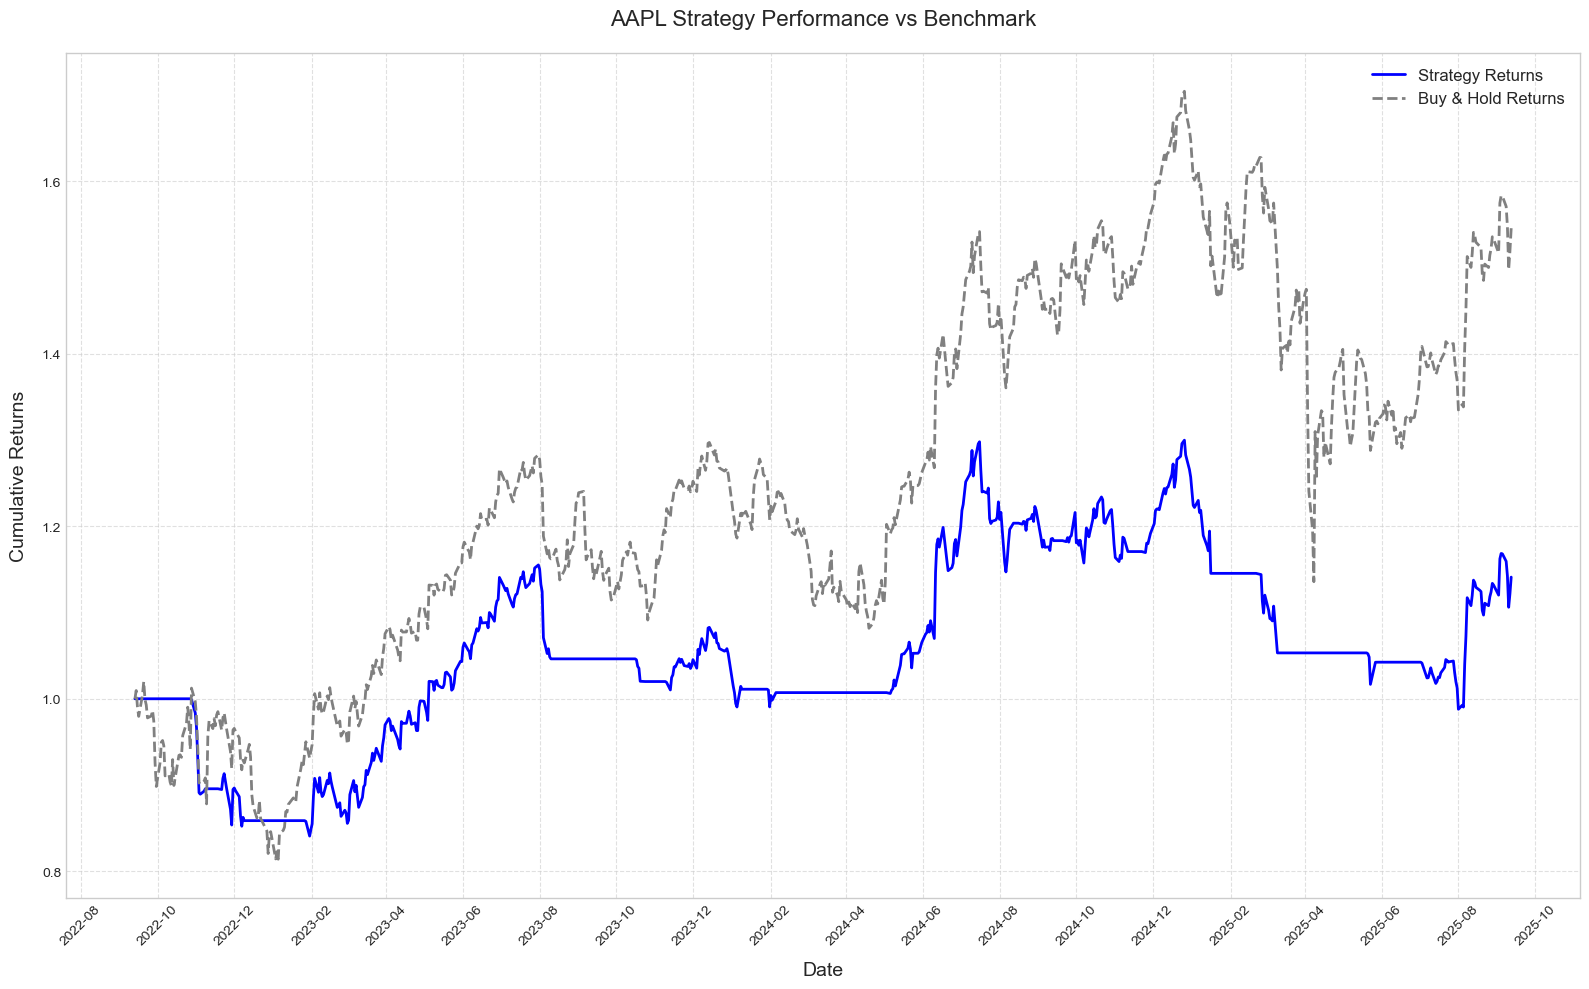

In [94]:
SHORT_WINDOW = 10     # 5-day moving average
LONG_WINDOW = 50     # 20-day moving average
LAST_N_DAYS = 360    # Plot only last 180 days for better visibility
INITIAL_CAPITAL = 10000
TRANSACTION_COST=0.001

stock_data_with_ma = calculate_moving_averages(
    stock_data,
    short_window=SHORT_WINDOW,
    long_window=LONG_WINDOW
)

stock_data_with_signals = generate_signals(stock_data_with_ma)

print("\nRunning strategy backtest...")
backtest_results, trades_df = backtest(
            stock_data_with_signals,
            initial_capital=INITIAL_CAPITAL,
            transaction_cost=TRANSACTION_COST,
        )

metrics = calculate_performance_metrics(backtest_results, trades_df)
print_performance_metrics(metrics)

print("\nLatest data with signals:")
display(stock_data_with_signals[['close', 'ma_short', 'ma_long', 'signal']].tail(10))

plot_strategy(
    stock_data_with_signals,
    SYMBOL,
    SHORT_WINDOW,
    LONG_WINDOW,
    last_n_days=LAST_N_DAYS
)

plot_performance(backtest_results, SYMBOL)